## Regression data analysis: multiply linear regression (MLR) and Assumtions

**Objective:** 

At this stage, the focus is on finalizing the model development and ensuring its accuracy and reliability. The key tasks include:

 - Select the modeling approach – Identify the best regression model for TLC data.

 - Build the regression model – Develop and refine it using TLC datasets.

 - Validate model assumptions – Ensure statistical integrity.

 - Evaluate performance – Measure accuracy using relevant metrics.

 - Interpret model results and summarize findings for stakeholders within TLC.


### Imports

In [24]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations
from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [25]:
df0 = pd.read_csv('data/2017_Yellow_Taxi_Trip_Data.csv')
print("Data loaded successfully")

Data loaded successfully


### Data exploration (EDA)

Looking for correlations, missing data, outliers, and duplicates.

In [26]:
# saving original data set
df = df0.copy()

print(df.shape)

df.info()

(22699, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  flo

In [27]:
# checking for duplicates
print('Shape of dataframe:', df.shape)
print('Shape of dataframe with duplicates dropped:', df.drop_duplicates().shape)

# missing values in dataframe
print('Total count of missing values:', df.isna().sum().sum())

print('Missing values per column:')
df.isna().sum()

Shape of dataframe: (22699, 18)
Shape of dataframe with duplicates dropped: (22699, 18)
Total count of missing values: 0
Missing values per column:


Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

There are no duplicates or missing values in the data.

In [28]:
# Descriptive statistics
df.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


There are clearly some outliers in several variables: `tip_amount` (\$200) and `total_amount` (\$1,200). 

Also, a number of the variables, such as `mta_tax`, seem to be almost constant throughout the data, which would imply that they would not be expected to be very predictive.

### Convert pickup & dropoff columns to datetime

In [29]:
# Check the format of the data
df['tpep_dropoff_datetime'][0]

'03/25/2017 9:09:47 AM'

In [30]:
# Display data types before convertation
print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

# Convert to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Display data types after convertation
print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

df.head(5)

Data type of tpep_pickup_datetime: object
Data type of tpep_dropoff_datetime: object
Data type of tpep_pickup_datetime: datetime64[ns]
Data type of tpep_dropoff_datetime: datetime64[ns]


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


### Create duration column

Represents the total number of minutes that each taxi ride took

In [31]:
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

### Outliers

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

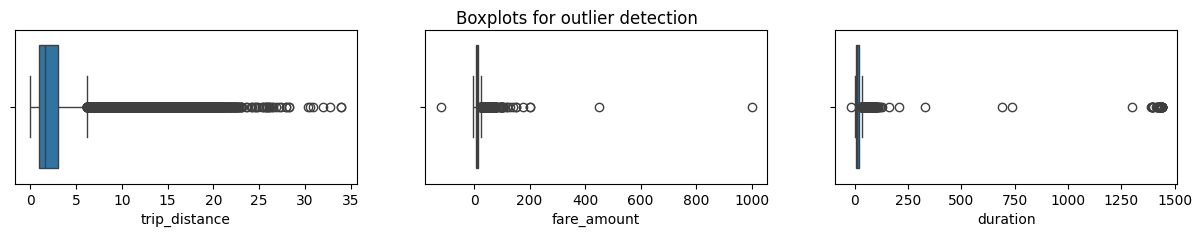

In [33]:
# Box plot for each feature: `trip_distance`, `fare_amount`, `duration`.
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df['trip_distance'])
sns.boxplot(ax=axes[1], x=df['fare_amount'])
sns.boxplot(ax=axes[2], x=df['duration'])
plt.show();

All three variables contain outliers, some of which are extreme, while others are less significant.

The `trip_distance` from the southern tip of Staten Island to the northern end of Manhattan is 30 miles in a straight line. Considering this and the distribution of values in this column, it is reasonable to leave these values unchanged. However, `fare_amount` and `duration` show problematic outliers on the higher end.

Adjustments may be necessary for these two variables, but for `trip_distance`, keeping the values as they are seems acceptable.

#### `trip_distance` outliers

Are trip distances of 0 bad data or very short trips rounded down?

In [34]:
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [36]:
# Calculate the count of rides where the `trip_distance` is zero.
sum(df['trip_distance']==0)

148

148 out of ~23,000 rides is relatively insignificant. We could impute it with a value of 0.01, but it's unlikely to have much of an effect on the model. Therefore, the `trip_distance` column will remain untouched with regard to outliers.

#### `fare_amount` outliers

In [37]:
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

The range of values in the `fare_amount` column is large and the extremes don't make much sense.

* Negative values are problematic. Values of zero could be legitimate if the taxi logged a trip that was immediately canceled.

* The maximum fare amount in this dataset is nearly \\$1,000, which seems very unlikely. High values for this feature can be capped based on intuition and statistics. The interquartile range (IQR) is \\$8. The standard formula of `Q3 + (1.5 * IQR)` yields \$26.50. That doesn't seem appropriate for the maximum fare cap. In this case, we'll use a factor of `6`, which results in a cap of $62.50.

* Impute values less than $0 with `0`.

In [38]:
# Impute values less than $0 with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
df['fare_amount'].min()

np.float64(0.0)

In [39]:
# Impute the maximum value as `Q3 + (6 * IQR)`
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [40]:
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



#### `duration` outliers

In [42]:
df['duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

The `duration` column has problematic values at both the lower and upper extremities.

* There should be no values that represent negative time. Impute all negative durations with `0`.

* Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [43]:
# Impute a 0 for any negative values
df.loc[df['duration'] < 0, 'duration'] = 0
df['duration'].min()

np.float64(0.0)

In [44]:
# Impute the high outliers
outlier_imputer(['duration'], 6)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64



### Feature engineering

#### Add `mean_distance` column

When deployed, the model will not know the duration of a trip until after the trip occurs, so you cannot train a model that uses this feature. However, you can use the statistics of trips you *do* know to generalize about ones you do not know. In this step, create a column called `mean_distance` that captures the mean distance for each group of trips that share pickup and dropoff points.

In [46]:
# Creating a helper column called `pickup_dropoff`, which contains the unique combination of pickup and dropoff location IDs for each row.
df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
df['pickup_dropoff'].head(2)

0    100 231
1     186 43
Name: pickup_dropoff, dtype: object

In [47]:
# group each row by the new `pickup_dropoff` column, compute the mean, and capture the values only in the `trip_distance` column. 
# Assign the results to a variable named `grouped`
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
grouped[:5]

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [49]:
# 1. Convert `grouped` to a dictionary
grouped_dict = grouped.to_dict()

# 2. Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']

In [50]:
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
df['mean_distance'] = df['pickup_dropoff']

# 2. Map `grouped_dict` to the `mean_distance` column
# Note that `map()` will impute `NaN` for any values in the series that do not have a corresponding key in the mapping dictionary, so be careful.
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# Confirm that it worked
df[(df['PULocationID']==100) & (df['DOLocationID']==231)][['mean_distance']]

,mean_distance
0,3.521667
4909,3.521667
16636,3.521667
18134,3.521667
19761,3.521667
20581,3.521667


#### Add `mean_duration` column

In [65]:
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]
grouped

# Create a dictionary where keys are unique pickup_dropoffs and values are
# mean trip duration for all trips with those pickup_dropoff combos
grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# Confirm that it worked
df[(df['PULocationID']==100) & (df['DOLocationID']==231)][['mean_duration']]

,mean_duration
0,22.847222
4909,22.847222
16636,22.847222
18134,22.847222
19761,22.847222
20581,22.847222


#### Add `day` and `month` columns

Two new columns, `day` (name of day) and `month` (name of month) by extracting the relevant information from the `tpep_pickup_datetime` column.

In [66]:
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

#### Add `rush_hour` column

In [67]:
# Create 'rush_hour' col
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

# If day is Saturday or Sunday, impute 0 in `rush_hour` column
df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

In [68]:
# Binary `rush_hour` column that contains a 1 if the ride was during rush hour and a 0 if it was not
# Any weekday (not Saturday or Sunday) AND either from 06:00-10:00 or from 16:00-20:00
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [69]:
# Apply the `rush_hourizer()` function to the new column
# Explicitly cast the assigned value to int32 before updating the DataFrame to preventing future errors (pandas will soon stop allowing incompatible dtype assignments)
df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1).astype('int32')
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,day,month,rush_hour,mean_duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.3,16.56,14.066667,100 231,3.521667,saturday,mar,0,22.847222
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.3,20.80,26.500000,186 43,3.108889,tuesday,apr,0,24.470370
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.3,8.75,7.200000,262 236,0.881429,friday,dec,1,7.250000
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.3,27.69,30.250000,188 97,3.700000,sunday,may,0,30.250000
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.0,0.3,17.80,16.716667,4 112,4.435000,saturday,apr,0,14.616667


### Scatter plot to visualize the relationship between `mean_duration` and `fare_amount`

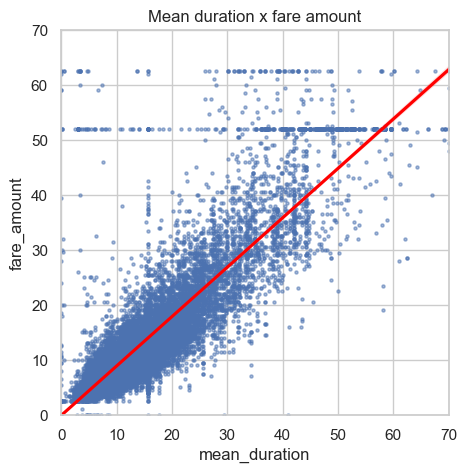

In [78]:
# Create a scatter plot of duration and trip_distance, with a line of best fit
sns.set(style='whitegrid')
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
sns.regplot(x=df['mean_duration'], y=df['fare_amount'],
            scatter_kws={'alpha':0.5, 's':5},
            line_kws={'color':'red'})
plt.ylim(0, 70)
plt.xlim(0, 70)
plt.title('Mean duration x fare amount')
plt.show()

The `mean_duration` variable correlates with the target variable. One of the lines represents 62 dollars and 50 cents is the maximum that was imputed for outliers, so all former outliers will now have fare amounts of \$62.50.

In [72]:
# Check the value of the rides in the second horizontal line in the scatter plot
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: count, dtype: int64

There are 514 trips whose fares were \$52.

In [75]:
# Examine the first 30 of these trips
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df[df['fare_amount']==52].head(30)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,day,month,rush_hour,mean_duration
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,36.800000,236 132,19.211667,sunday,mar,0,40.500000
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,N,132,163,1,52.0,0.0,0.5,0.00,0.00,0.3,52.80,66.850000,132 163,19.229000,saturday,jun,0,52.941667
161,95729204,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,0.966667,132 132,2.255862,saturday,nov,0,3.021839
247,103404868,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,N,132,79,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,29.183333,132 79,19.431667,wednesday,dec,0,47.275000
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,N,132,234,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,29.483333,132 234,17.654000,sunday,sep,0,49.833333
388,16226157,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,N,132,48,2,52.0,4.5,0.5,0.00,5.54,0.3,62.84,39.833333,132 48,18.761905,tuesday,feb,1,58.246032
406,55253442,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,N,228,88,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,15.616667,228 88,4.730000,monday,jun,0,15.616667
449,65900029,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,N,132,48,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,45.450000,132 48,18.761905,thursday,aug,0,58.246032
468,80904240,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,N,186,132,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,42.850000,186 132,17.096000,tuesday,sep,0,42.920000
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,N,132,148,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,71.583333,132 148,17.994286,sunday,apr,0,46.340476


It seems that almost all of the trips in the first 30 rows where the fare amount was \$52 either begin or end at location 132, and all of them have a `RatecodeID` of 2.

There is no readily apparent reason why PULocation 132 should have so many fares of 52 dollars. They seem to occur on all different days, at different times, with both vendors, in all months. However, there are many toll amounts of $5.76 and \\$5.54. This would seem to indicate that location 132 is in an area that frequently requires tolls to get to and from. It's likely this is an airport.


The data dictionary says that `RatecodeID` of 2 indicates trips for JFK, which is John F. Kennedy International Airport. A quick Google search for "new york city taxi flat rate \$52" indicates that in 2017 (the year that this data was collected) there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan.

Because `RatecodeID` is known from the data dictionary, the values for this rate code can be imputed back into the data after the model makes its predictions. This way you know that those data points will always be correct.

### Isolate modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

In [77]:
df2 = df.copy()

df2 = df2.drop(['Unnamed: 0', 'tpep_dropoff_datetime', 'tpep_pickup_datetime',
               'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
               'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
               'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'duration',
               'pickup_dropoff', 'day', 'month'
               ], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   rush_hour        22699 non-null  int32  
 5   mean_duration    22699 non-null  float64
dtypes: float64(3), int32(1), int64(2)
memory usage: 975.5 KB


### Pair plot to visualize pairwise relationships between `fare_amount`, `mean_duration`, and `mean_distance`

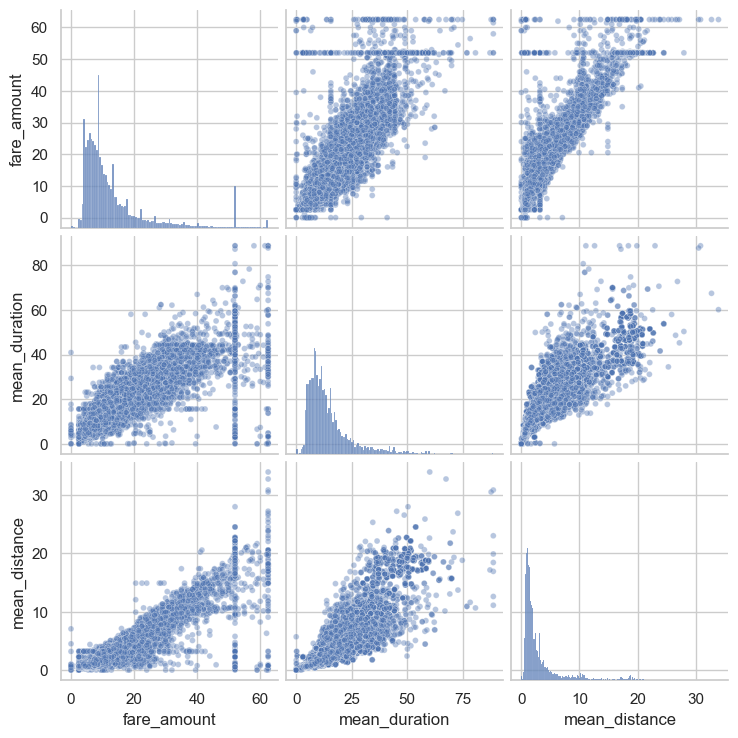

In [79]:
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.4, 'size':5},
             );

These variables all show linear correlation with each other. Investigate this further.

### Identify correlations to help determine most correlated variables

In [80]:
# Create correlation matrix containing pairwise correlation of columns, using pearson correlation coefficient
df2.corr(method='pearson')

,VendorID,passenger_count,fare_amount,mean_distance,rush_hour,mean_duration
VendorID,1.000000,0.266463,0.001045,0.004741,-0.002874,0.001876
passenger_count,0.266463,1.000000,0.014942,0.013428,-0.022035,0.015852
fare_amount,0.001045,0.014942,1.000000,0.910185,-0.020075,0.859105
mean_distance,0.004741,0.013428,0.910185,1.000000,-0.039725,0.874864
rush_hour,-0.002874,-0.022035,-0.020075,-0.039725,1.000000,-0.021583
mean_duration,0.001876,0.015852,0.859105,0.874864,-0.021583,1.000000


#### Visualize a correlation heatmap of the data

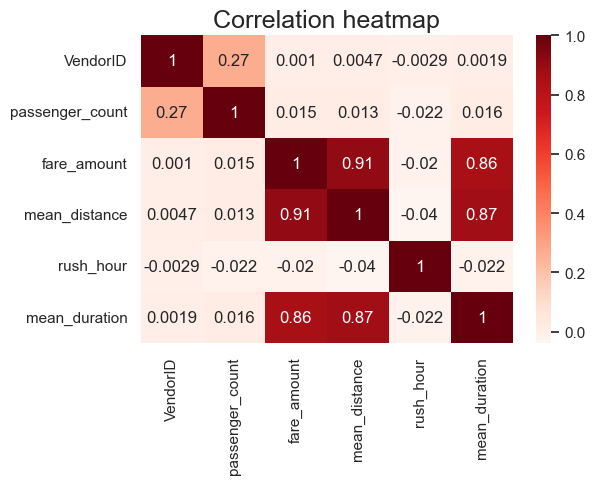

In [81]:
plt.figure(figsize=(6,4))
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=18)
plt.show()

`mean_duration` and `mean_distance` are both highly correlated with the target variable of `fare_amount` They're also both correlated with each other, with a Pearson correlation of 0.87.

**Recall** that highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model. However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to learn about your data.

This model will predict `fare_amount`, which will be used as a predictor variable in machine learning models. Therefore, try modeling with both variables even though they are correlated.

## Split data into outcome variable and features

In [82]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   rush_hour        22699 non-null  int32  
 5   mean_duration    22699 non-null  float64
dtypes: float64(3), int32(1), int64(2)
memory usage: 975.5 KB


In [83]:
# Set X and y variables
# X represents the features and y represents the outcome (target) variable
# Remove the target column from the features
X = df2.drop(columns=['fare_amount'])

# Set y variable
y = df2[['fare_amount']]

# Display first few rows
X.head()

,VendorID,passenger_count,mean_distance,rush_hour,mean_duration
0,2,6,3.521667,0,22.847222
1,1,1,3.108889,0,24.470370
2,1,1,0.881429,1,7.250000
3,2,1,3.700000,0,30.250000
4,2,1,4.435000,0,14.616667


### Pre-process data

In [84]:
# Convert VendorID to string
X['VendorID'] = X['VendorID'].astype(str)

# Get dummies
X = pd.get_dummies(X, drop_first=True)
X.head()

,passenger_count,mean_distance,rush_hour,mean_duration,VendorID_2
0,6,3.521667,0,22.847222,True
1,1,3.108889,0,24.470370,False
2,1,0.881429,1,7.250000,False
3,1,3.700000,0,30.250000,True
4,1,4.435000,0,14.616667,True


### Split data into training and test sets

In [85]:
# Create training and testing sets
# The test set should contain 20% of the total samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Standardize the data

In [87]:
# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
print('X_train scaled:', X_train_scaled)

X_train scaled: [[-0.50301524  0.8694684  -0.64893329  0.17616665  0.89286563]
 [-0.50301524 -0.60011281  1.54099045 -0.69829589  0.89286563]
 [ 0.27331093 -0.47829156 -0.64893329 -0.57301906 -1.11998936]
 ...
 [-0.50301524 -0.45121122 -0.64893329 -0.6788917  -1.11998936]
 [-0.50301524 -0.58944763  1.54099045 -0.85743597 -1.11998936]
 [ 1.82596329  0.83673851 -0.64893329  1.13212101  0.89286563]]


### Fit the model

In [89]:
# Fit your model to the training data
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

### Evaluate model

### Train data

In [93]:
# Evaluate the model performance (by calculating the residual sum of squares and the explained variance score (R^2)) on the training data
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
# Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.8398434585044773
R^2: 0.8398434585044773
MAE: 2.186666416775414
MSE: 17.88973296349268
RMSE: 4.229625629236313


### Test data

In [91]:
# Scale the X_test data
X_test_scaled = scaler.transform(X_test)

In [94]:
# Evaluate the model performance on the testing data
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.8682583641795454
R^2: 0.8682583641795454
MAE: 2.1336549840593864
MSE: 14.326454156998945
RMSE: 3.785030271609323


The model performance is high on both training and test sets, suggesting that there is little bias in the model and that the model is not overfit. In fact, the test scores were even better than the training scores.

For the test data, an R<sup>2</sup> of 0.868 means that 86.8% of the variance in the `fare_amount` variable is described by the model.

The mean absolute error is informative here because, for the purposes of the model, an error of two is not more than twice as bad as an error of one.

## Results

In [95]:
# Results dataframe
results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,12.356503,1.643497
18134,28.0,16.314595,11.685405
4655,5.5,6.726789,-1.226789
7378,15.5,16.227206,-0.727206
13914,9.5,10.536408,-1.036408


### Visualize model results

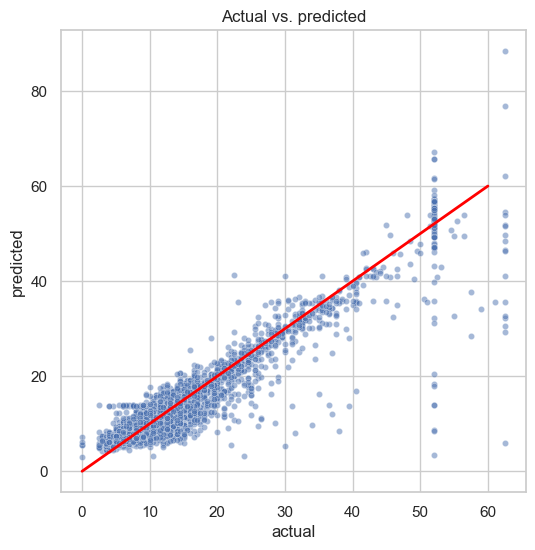

In [96]:
# Scatterplot to visualize `predicted` over `actual`
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

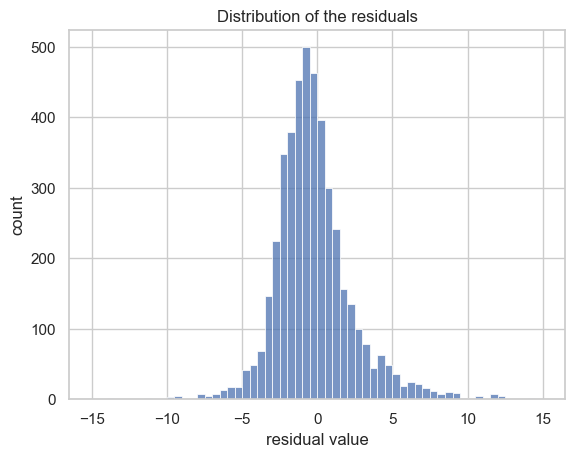

In [97]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

In [98]:
results['residual'].mean()

np.float64(-0.015442621528680794)

The distribution of the residuals is approximately normal and has a mean of -0.015. The residuals represent the variance in the outcome variable that is not explained by the model. A normal distribution around zero is good, as it demonstrates that the model's errors are evenly distributed and unbiased.

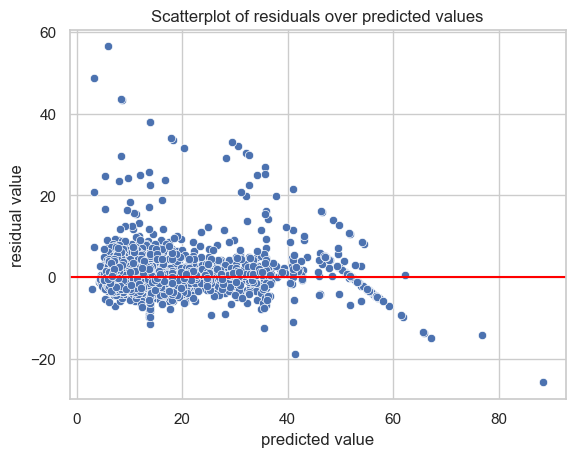

In [99]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x='predicted', y='residual', data=results)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

The model's residuals are evenly distributed above and below zero, with the exception of the sloping lines from the upper-left corner to the lower-right corner, which you know are the imputed maximum of \\$62.50 and the flat rate of \\$52 for JFK airport trips.

### Coefficients

In [100]:
# Get model coefficients
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,mean_distance,rush_hour,mean_duration,VendorID_2
0,0.030825,7.133867,0.110233,2.812115,-0.054373


#### Interpreting the mean_distance coefficient in a linear regression model:

After training a linear regression model using standardized features (via StandardScaler), the `mean_distance` variable turned out to be the most significant: its coefficient is 7.13. However, it is important to understand that this coefficient reflects the change in the target variable `fare_amount` when the feature changes by one standard value, not by one mile.

Since the features were standardized, the units are no longer expressed in miles, but in standard deviations. Therefore, it is incorrect to interpret the result as "an increase in the cost of a trip by $7.13 for each additional mile".

To convert the coefficient back to real units (in this case, miles), we need to perform the inverse transformation:

1. Calculate the standard deviation of the `mean_distance` feature in the original (non-standardized) training data `X_train`.

2. Divide the coefficient (7.133867) by the result to yield a more intuitive interpretation.

In [101]:
# 1. Calculate SD of `mean_distance` in X_train data
print(X_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation
print(7.133867 / X_train['mean_distance'].std())

3.574812975256436
1.9955916713344308


For every 3.57 miles traveled, the fare increased by a mean of \\$7.13. Or, reduced: for every 1 mile traveled, the fare increased by a mean of \\$2.00.

#### Prediction on full dataset

In [102]:
X_scaled = scaler.transform(X)
y_preds_full = lr.predict(X_scaled)

#### Impute ratecode 2 fare

The data dictionary says that the `RatecodeID` column captures the following information:

1 = standard rate  
2 = JFK (airport)  
3 = Newark (airport)  
4 = Nassau or Westchester  
5 = Negotiated fare  
6 = Group ride  

This means that some fares don't need to be predicted. They can simply be imputed based on their rate code. Specifically, all rate codes of `2` can be imputed with \$52, as this is a flat rate for JFK airport. The other rate codes have some variation (not shown here, but feel free to check for yourself). They aren't a fixed rate, so these fares will remain untouched.

In [103]:
# Create a new df containing just the RatecodeID col from the whole dataset
final_preds = df[['RatecodeID']].copy()

# Add a column containing all the predictions
final_preds['y_preds_full'] = y_preds_full

# Impute a prediction of 52 at all rows where RatecodeID == 2
final_preds.loc[final_preds['RatecodeID']==2, 'y_preds_full'] = 52

# Check that it worked
final_preds[final_preds['RatecodeID']==2].head()

,RatecodeID,y_preds_full
11,2,52.0
110,2,52.0
161,2,52.0
247,2,52.0
379,2,52.0


#### Performance on full dataset

In [104]:
final_preds = final_preds['y_preds_full']
print('R^2:', r2_score(y, final_preds))
print('MAE:', mean_absolute_error(y, final_preds))
print('MSE:', mean_squared_error(y, final_preds))
print('RMSE:',np.sqrt(mean_squared_error(y, final_preds)))

R^2: 0.8910853978683975
MAE: 1.992506252269974
MSE: 12.101575504689935
RMSE: 3.4787318816905013


#### Final predictions with `mean_duration` and `mean_distance` columns

In [105]:
# Combine means columns with predictions column
nyc_preds_means = df[['mean_duration', 'mean_distance']].copy()
nyc_preds_means['predicted_fare'] = final_preds
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642
